In [1]:
from noiseBudgetModule import noiseBudget
import numpy as np
import matplotlib.pyplot as plt  # For plotting
from matplotlib.backends.backend_pdf import PdfPages       #For saving figures to single pdf
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as colors
figlist = []
#*******************************************************************************************************
#Setting RC Parameters for figure size and fontsizes
import matplotlib.pylab as pylab                           
params = {'figure.figsize': (16, 12),
          'xtick.labelsize':'xx-large',
          'ytick.labelsize':'xx-large',
          'text.usetex': False,
          'lines.linewidth': 4,
          'font.family': 'serif',
          'font.serif': 'Georgia',
          'font.size': 20,
          'xtick.direction': 'in',
          'ytick.direction': 'in',
          'xtick.labelsize': 'medium',
          'ytick.labelsize': 'medium',
          'axes.labelsize': 'medium',
          'axes.titlesize':'medium',
          'axes.grid.axis': 'both',
          'axes.grid.which': 'both',
          'axes.grid': True,
          'grid.color': 'xkcd:cement',
          'grid.alpha': 0.3,
          'lines.markersize': 12,
          'lines.linewidth': 2.0,
          'legend.borderpad': 0.2,
          'legend.fancybox': True,
          'legend.fontsize': 'medium',
          'legend.framealpha': 0.8,
          'legend.handletextpad': 0.5,
          'legend.labelspacing': 0.33,
          'legend.loc': 'best',
          'savefig.dpi': 140,
          'savefig.bbox': 'tight',
          'pdf.compression': 9}
pylab.rcParams.update(params)
#********************************************************************************************************
from uncertainties import ufloat as uf
from uncertainties import unumpy as unp
import scipy.constants as scc
from scipy.stats import norm, chi2
import os
import time
from collections.abc import Iterable
from IPython.display import clear_output
import sys
import yaml
figlist = []

In [2]:
def cleanData(ff, beat, lowerFreqCutOff=50, upperFreqCutOff=600, threshold=2.5e-5):
    repeatInd = []
    for ii in range(1, len(ff)):
        if ff[ii] == ff[ii-1]:
            repeatInd += [ii]
    ff = np.delete(ff, repeatInd)
    beat = np.delete(beat, repeatInd)
    beat = beat[ff < upperFreqCutOff]
    ff = ff[ff < upperFreqCutOff]
    beat = beat[ff > lowerFreqCutOff]
    ff = ff[ff > lowerFreqCutOff]
    beatDer = (beat[1:] - beat[:-1])/(ff[1:] - ff[:-1])
    peakInd = []
    for ii in range(len(beatDer)):
        if np.abs(beatDer[ii])>1e-5:
            if ii-1>0:
                peakInd = list(set(peakInd + [ii-1]))
            if ii+1<len(beatDer):
                peakInd = list(set(peakInd + [ii+1]))
            peakInd = list(set(peakInd + [ii]))
    # Always remove the last point
    peakInd = list(set(peakInd + [len(beatDer)-1]))
    return np.delete(ff, peakInd), np.delete(beat, peakInd)

In [3]:
dataDir = ['/Users/anchal/Git/cit_ctnlab/ctn_labdata/data/20200313_SuperBNMeasurement/Data/',
           '/Users/anchal/Git/cit_ctnlab/ctn_labdata/data/20200420_SuperBNMeasurement/Data/',
           '/Users/anchal/Git/cit_ctnlab/ctn_labdata/data/20200511_SuperBNMeasurement/Data/',
           '/Users/anchal/Git/cit_ctnlab/ctn_labdata/data/20200521_SuperBNMeasurement/Data/',
           '/Users/anchal/Git/cit_ctnlab/ctn_labdata/data/20200523_SuperBNMeasurementSR/Data/',
           '/Users/anchal/Git/cit_ctnlab/ctn_noisebudget/Data/dailyBeatNoteData/']
allMeasurements = {}
for direc in dataDir:
    fl = [fn for fn in os.listdir(direc) if fn.find('Spectrum')!=-1]
    for fn in fl:
        data = np.loadtxt(direc+fn)
        ffclean, beatclean = cleanData(data[:, 0], data[:, 1])
        intNoise = np.sum(beatclean)
        # startInd = np.argmin(np.abs(ff - 200))
        # stopInd = np.argmin(np.abs(ff - 600))+1
        # intNoise = np.sum(data[startInd:stopInd, 1] * (ff[startInd+1:stopInd+1]-ff[startInd:stopInd]))
        allMeasurements[direc+fn] = intNoise

In [4]:
temp = min(allMeasurements.values()) 
lowestNoiseFiles = [key for key in allMeasurements if allMeasurements[key] == temp] 
print(lowestNoiseFiles)

['/Users/anchal/Git/cit_ctnlab/ctn_labdata/data/20200523_SuperBNMeasurementSR/Data/BeatnoteSpectrum_20200526_090335.txt']


In [5]:
cwd = os.getcwd()
os.chdir('/Users/anchal/Git/cit_ctnlab/ctn_noisebudget/Data/SavedPSDs_20200417/')
nosbud = noiseBudget(params='CTN_Noise_Budget_Diff_Loss_Angles.yml')
os.chdir(cwd)
nosbud.calculateCoatingBrownianNoise();

Creating coating stack for the noise budget...
Using Hong et al . PRD 87, 082001 (2013) to calculate parameters for coating brownian noise
Wait 1 to 2 minutes ...
Using Evans et al . PRD 78, 102003 (2008) to calculatecoefficients for thermo-optic noise
Wait 30 to 90 seconds ...
Using Hong et al . PRD 87, 082001 (2013) to calculate coating brownian noise.
Typical calculation time is approximately 14 min.


In [6]:
nosbud.loadPSD('/Users/anchal/Git/cit_ctnlab/ctn_noisebudget/Data/SavedPSDs_20200417/SavedPSDs_20200507_163418.csv',
               overridePresentFreq=True)
nosbud.calculateTotalEstNoise()
BNfile = lowestNoiseFiles[-1]
#BNfile = '/Users/anchal/Git/cit_ctnlab/ctn_noisebudget/Data/dailyBeatNoteData/BeatnoteSpectrum_20200311_193021.txt'
#BNfile = '/Users/anchal/Git/cit_ctnlab/ctn_noisebudget/Data/dailyBeatNoteData/BeatnoteSpectrum_20200506_025333.txt'
nosbud.loadASD(BNfile,
               label='Measured Beatnote Spectrum',
               key='beat')

Found lower and upper bounds
Adding photoThermal
Adding PT_wo_RIN_coatAbs
Skipping coatBr
Skipping coatBrPh
Skipping coatBrAmp
Adding coatTO
Adding coatTE
Adding coatTR
Adding subBr
Adding subTE
Adding pdhShot
Found lower and upper bounds
Adding pllOsc
Adding pllReadout
Adding seismic
Adding resNPRO
Found lower and upper bounds
Adding total
Found lower and upper bounds


In [7]:
transRINfile = BNfile.replace('Spectrum', 'TransRIN')
if os.path.exists(transRINfile):
    RINdata = np.loadtxt(transRINfile)
    with open(transRINfile, 'r') as f:
        header = f.readline()
    temp = header[header.find('North DC Val:')+13:].replace(' ', '')
    NDC = float(temp.split('Volts')[0])
    temp = header[header.find('South DC Val:')+13:].replace(' ', '')
    SDC = float(temp.split('Volts')[0])
    cpb = int((np.shape(RINdata)[1]-1)/2)
    RINdata[:, 1:cpb+1] = RINdata[:, 1:cpb+1]/NDC
    RINdata[:, cpb+1:] = RINdata[:, cpb+1:]/SDC
    nosbud.updatePhotoThermalNoise(RINdata, uf(6, 1) * 1e-6)

In [8]:
expConfigfile = BNfile.replace('Spectrum', 'ExpConfig').replace('.txt', '.yml')
if os.path.exists(expConfigfile):
    with open(expConfigfile, 'r') as f:
        ExpConfig = yaml.full_load(f)
    if 'duration' in ExpConfig:
        duration = ExpConfig['duration']
    else:
        print('Assuming 60s of measurement.')
        duration = 60

(0.05, 20000.0)

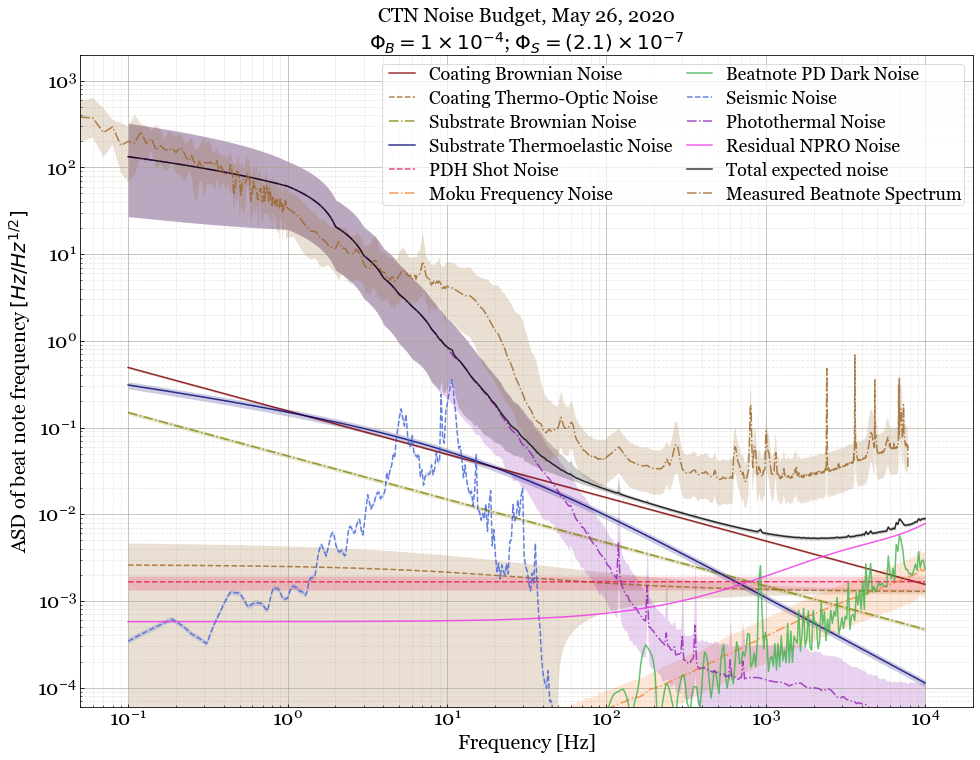

In [9]:
plotList = ['coatBr', 'coatTO', 'subBr', 'subTE',
            'pdhShot', 'pllOsc', 'pllReadout', 'seismic',
            'photoThermal', 'resNPRO', 'total', 'beat']
fig = nosbud.plotPSD(plotList=plotList,
                     savePlot=False,
                     doTotal=True)
fn = BNfile.replace('.txt', '')
tstamp = fn[fn.find('Spectrum_')+9:]
tstruc = time.strptime(tstamp, '%Y%m%d_%H%M%S')
BNdate = time.strftime('%b %d, %Y', tstruc)
ax = fig.gca()
ax.set_title('CTN Noise Budget, '+BNdate+'\n'+r'$\Phi_B=1 \times10^{-4}$; $\Phi_S=(2.1) \times10^{-7}$')
ax.set_xlim([0.05, 2e4])

In [10]:
# Bulk
def S_Bk_red(freq, nosbud):
    S_Bk_num = (4*scc.Boltzmann*nosbud.temp*nosbud.coatStack.WaveLength
                        * (1 - nosbud.coatStack.Poisson
                           - 2*nosbud.coatStack.Poisson**2))
    S_Bk_den = (3*np.pi*freq*nosbud.coatStack.Young
                        * ((1 - nosbud.coatStack.Poisson)**2)
                        * nosbud.coatStack.Aeff)
            # Leaving out substrate from return value
    return (S_Bk_num/S_Bk_den)[0:-1]

# Shear
def S_Sk_red(freq, nosbud):
    S_Sk_num = (4*scc.Boltzmann*nosbud.temp*nosbud.coatStack.WaveLength
                        * (1 - nosbud.coatStack.Poisson
                           - 2*nosbud.coatStack.Poisson**2))
    S_Sk_den = (3*np.pi*freq*nosbud.coatStack.Young
                        * ((1 - nosbud.coatStack.Poisson)**2)
                        * nosbud.coatStack.Aeff)
            # Leaving out substrate from return value
    return (S_Sk_num/S_Sk_den)[0:-1]

def BulkContSlope(freq, nosbud):
    if isinstance(freq, Iterable):
        return [BulkContSlope(f, nosbud) for f in freq]
    return nosbud.nom*(nosbud.fConv**2)*np.sum(nosbud.q_Bk*S_Bk_red(freq, nosbud))

def ShearContSlope(freq, nosbud):
    if isinstance(freq, Iterable):
        return [ShearContSlope(f, nosbud) for f in freq]
    return nosbud.nom*(nosbud.fConv**2)*np.sum(nosbud.q_Sk*S_Sk_red(freq, nosbud))

In [11]:
def Stot(LossBulk, LossShear, freqInd, nosbud):
    if isinstance(freqInd, Iterable):
        return [Stot(LossBulk, LossShear, fInd, nosbud) for fInd in freqInd]
    selFreq = nosbud.PSDList['coatBr'][1][freqInd]
    X_B = nosbud.nom*(nosbud.fConv**2)*np.sum(nosbud.q_Bk*S_Bk_red(selFreq, nosbud))
    X_S = nosbud.nom*(nosbud.fConv**2)*np.sum(nosbud.q_Sk*S_Sk_red(selFreq, nosbud))
    rest = ['coatTO', 'subBr', 'subTE', 'pdhShot',
            'pllOsc', 'pllReadout', 'seismic', 'photoThermal','resNPRO']
    S_rest = uf(0,0)
    for psd in rest:
        S_rest = S_rest + nosbud.PSDList[psd][0][freqInd]
    return S_rest + LossBulk*X_B + LossShear*X_S

def Srest(freq, nosbud):
    if isinstance(freq, Iterable):
        return [Srest(f, nosbud) for f in freq]
    rest = ['coatTO', 'subBr', 'subTE', 'pdhShot',
            'pllOsc', 'pllReadout', 'seismic', 'photoThermal','resNPRO']
    S_rest = uf(0,0)
    for psd in rest:
        freqInd = np.argmin(np.abs(nosbud.PSDList[psd][1] - freq))
        S_rest = S_rest + nosbud.PSDList[psd][0][freqInd]
    return S_rest

def lnlikelihood(measPSD, measPSDstd, measff, LossBulk, LossShear, freq, S_rest, X_B, X_S):
    if isinstance(freq, Iterable):
        lnlkh = 0
        for ii in range(len(freq)):
            lnlkh = lnlkh + lnlikelihood(measPSD, measPSDstd, measff,
                                         LossBulk, LossShear, freq[ii],
                                         S_rest[ii], X_B[ii], X_S[ii])
        return lnlkh
    measffind = np.argmin(np.abs(measff-freq))
    Stotal = S_rest + LossBulk*X_B + LossShear*X_S
    meas = measPSD[measffind]       # Median of the samples, taken as estimated mean
    measstd = measPSDstd[measffind] # Standard deviation of the samples   
    if Stotal.nominal_value > meas:
        return -np.inf # Would not let total noise more than measured noise.
    #return overlapBetweenTwoGaussians(Stotal.nominal_value, Stotal.std_dev, meas, measstd)
    return (#- np.log(Stotal.std_dev * np.sqrt(2*np.pi))
            - 0.5*((meas - Stotal.n)/ measstd)**2)

# Normal distributed prior based on Penn et al. measurements
def priorNphiB(phiB):
    priorMean = 5.33e-4
    priorStd = 0.03e-4
    prefac = 1/np.sqrt(2*np.pi)/priorStd
    exp = np.exp(-0.5*((priorMean -phiB)/priorStd)**2)
    return -0.5*((priorMean -phiB)/priorStd)**2
    # return prefac*exp

def priorNphiS(phiS):
    priorMean = 2.6e-7
    priorStd = 2.6e-7
    prefac = 1/np.sqrt(2*np.pi)/priorStd
    exp = np.exp(-0.5*((priorMean -phiS)/priorStd)**2)
    return -0.5*((priorMean -phiS)/priorStd)**2
    # return prefac*exp

# Uniformly distributed prior
def priorUphiB(phiB):
    if phiB>0 and phiB<100e-5:
        P_B = 0 
    else:
        P_B = -np.inf
    return P_B
def priorUphiS(phiS):
    if phiS>0 and phiS<94e-7:
        P_S = 0
    else:
        P_S = -np.inf
    return P_S

def prior(phiB, phiS):
    return priorUphiB(phiB) # + priorNphiS(phiS)

def createDist(measPSD, measPSDstd, measff, duration, freq, BulkLA, ShearLA, nosbud):
    X, Y = np.meshgrid(unp.nominal_values(BulkLA), unp.nominal_values(ShearLA))
    X_B = BulkContSlope(freq, nosbud)
    X_S = ShearContSlope(freq, nosbud)
    S_rest = Srest(freq, nosbud)
    lnbayProbDist = np.zeros(np.shape(X))
    lnpriorDist = np.zeros(np.shape(X))
    lnlkhDist = np.zeros(np.shape(X))
    ct = 0
    perc = 0
    for ii in range(len(ShearLA)):
        for jj in range(len(BulkLA)):
            lnpriorDist[ii][jj] = prior(BulkLA[jj], ShearLA[ii])
            lnlkhDist[ii][jj] = lnlikelihood(measPSD, measPSDstd,  measff,
                                         BulkLA[jj], ShearLA[ii],
                                         freq, S_rest, X_B, X_S)
            lnbayProbDist[ii][jj] = lnpriorDist[ii][jj] + lnlkhDist[ii][jj]
            ct = ct + 1
            lastperc = perc
            perc = np.round(ct*100/len(ShearLA)/len(BulkLA))
            if perc != lastperc:
                clear_output()
                print('{}% Completed'.format(perc))
                sys.stdout.flush()
    return lnbayProbDist, lnpriorDist, lnlkhDist

In [12]:
measff = nosbud.PSDList['beat'][1]
measPSD = nosbud.PSDList['beat'][0]
measPSDstd = np.abs(nosbud.PSDList['beat'][4] - nosbud.PSDList['beat'][3])/2

In [13]:
BulkLA = np.arange(0, 100e-5, 1e-7)
ShearLA = np.array([5.2e-7]) #np.arange(0, 6e-7, 1e-8)

In [14]:
cleanFreq, cleanPSD = cleanData(measff, measPSD,
                               lowerFreqCutOff=50, upperFreqCutOff=600)
bayProbDist, priorDist, lkhDist = createDist(measPSD, measPSDstd, measff, duration,
                                             freq=cleanFreq, BulkLA=BulkLA,
                                             ShearLA=ShearLA, nosbud=nosbud)

100.0% Completed


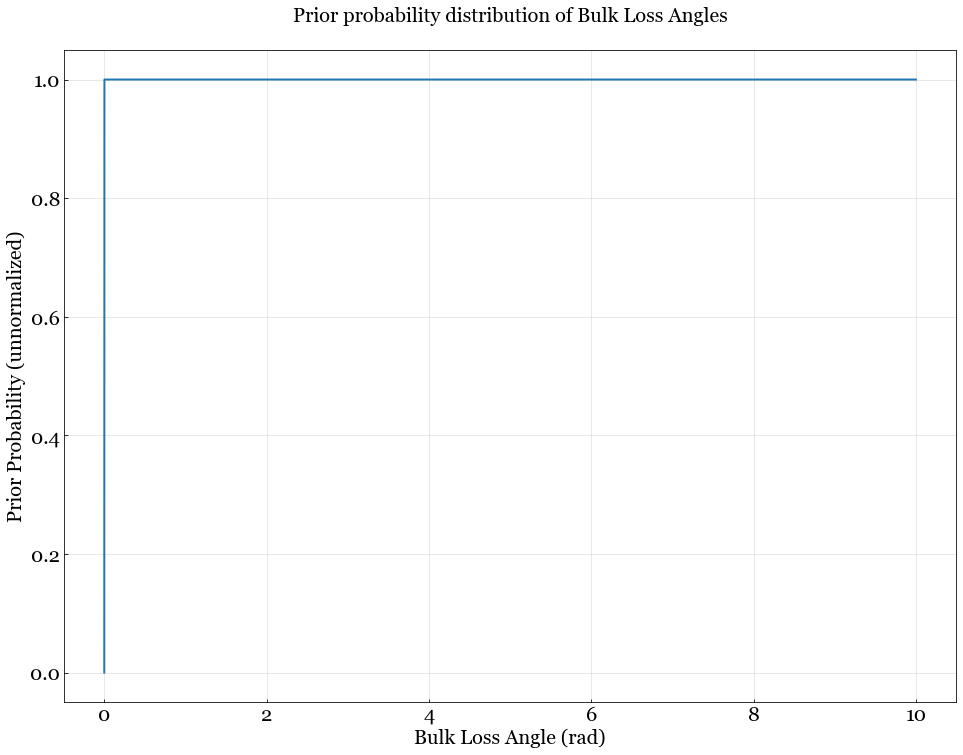

In [15]:
fig = plt.figure(figsize=[16,12])
ax = fig.gca()
ax.plot(BulkLA * 1e4, np.exp(priorDist[0, :]))
ax.set_title('Prior probability distribution of Bulk Loss Angles\n')
ax.set_xlabel('Bulk Loss Angle (rad)')
ax.set_ylabel('Prior Probability (unnormalized)')
figlist = [fig]

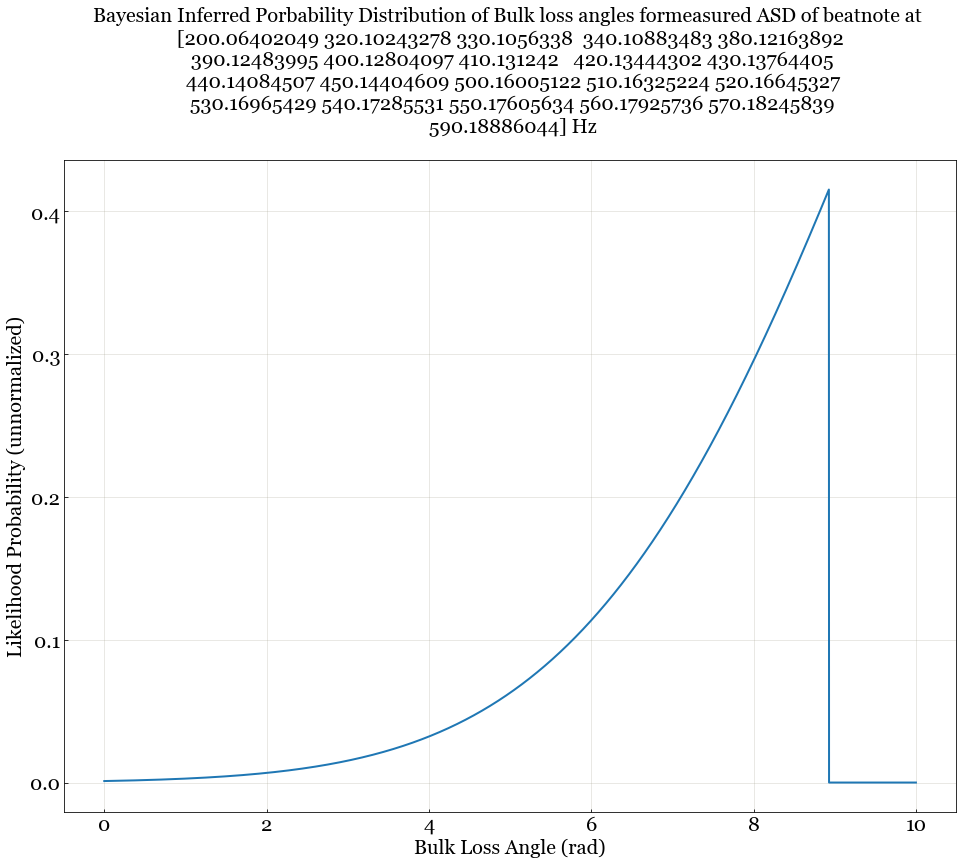

In [16]:
fig = plt.figure(figsize=[16,12])
ax = fig.gca()
ax.plot(BulkLA * 1e4, np.exp(lkhDist[0, :]))
ax.set_title('Bayesian Inferred Porbability Distribution of Bulk loss angles for'
             'measured ASD of beatnote at \n'
             + str(cleanFreq) + ' Hz\n')
ax.set_xlabel('Bulk Loss Angle (rad)')
ax.set_ylabel('Likelihood Probability (unnormalized)')
figlist += [fig]

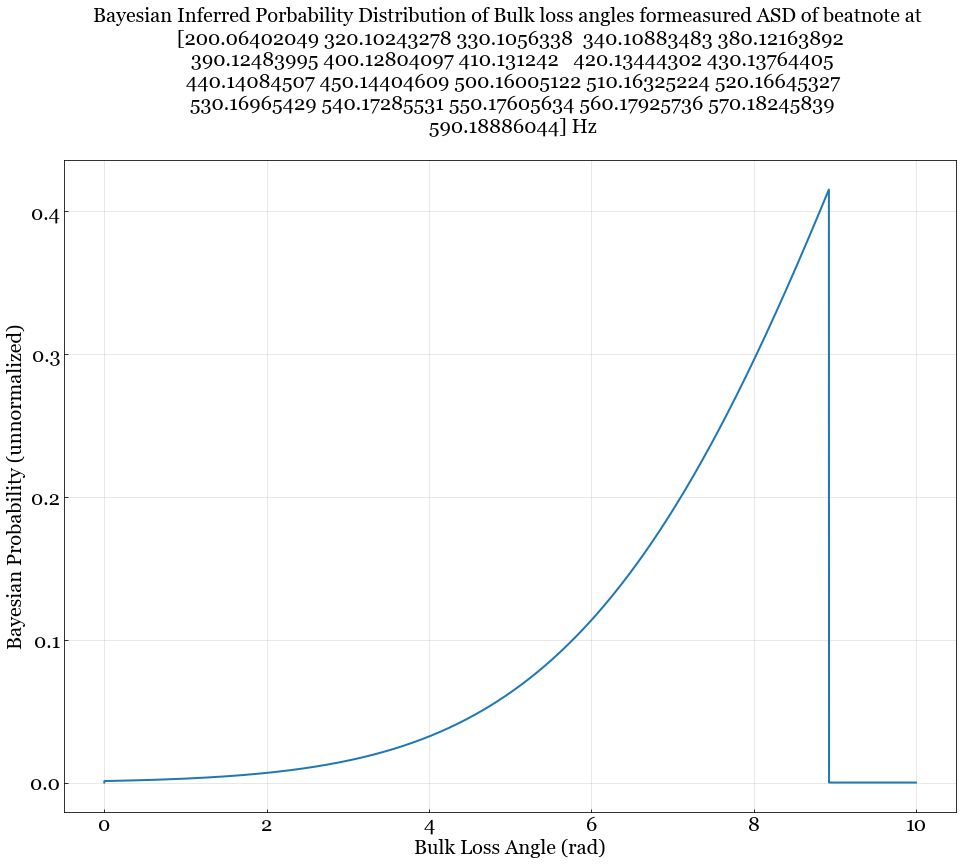

In [17]:
fig = plt.figure(figsize=[16,12])
ax = fig.gca()
ax.plot(BulkLA * 1e4, np.exp(bayProbDist[0, :]))
totArea = np.sum(np.exp(bayProbDist[0, :]))
for ii in range(len(BulkLA)):
    if np.sum(np.exp(bayProbDist[0, :ii])) >= 0.1*totArea:
        BLAci90lim = BulkLA[ii-1]
        break

mlBLA = BulkLA[np.argmax(bayProbDist[0, :])]
ax.set_title('Bayesian Inferred Porbability Distribution of Bulk loss angles for'
             'measured ASD of beatnote at \n'
             + str(cleanFreq) + ' Hz\n')
ax.set_xlabel('Bulk Loss Angle (rad)')
ax.set_ylabel('Bayesian Probability (unnormalized)')
figlist += [fig]

In [18]:
print('Estimated Bulk Loss Angle {:.2e} radians, with lower limit {:.2e} radians'.format(mlBLA, BLAci90lim))

Estimated Bulk Loss Angle 8.93e-04 radians, with lower limit 5.05e-04 radians


In [19]:
nosbud.coatStack.Loss = mlBLA 
nosbud.coatStack.LossShear = 5.2e-7
nosbud.coatStack.HongBrownianCoeffCalculations(nosbud.lam)
nosbud.coatStack.EvanThermoOpticCoeffCalculations(nosbud.lam)
nosbud.calculateCoatingBrownianNoise();

Using Hong et al . PRD 87, 082001 (2013) to calculate parameters for coating brownian noise
Wait 1 to 2 minutes ...
Using Evans et al . PRD 78, 102003 (2008) to calculatecoefficients for thermo-optic noise
Wait 30 to 90 seconds ...
Using Hong et al . PRD 87, 082001 (2013) to calculate coating brownian noise.
Typical calculation time is approximately 14 min.


Text(0.5, 1.0, '')

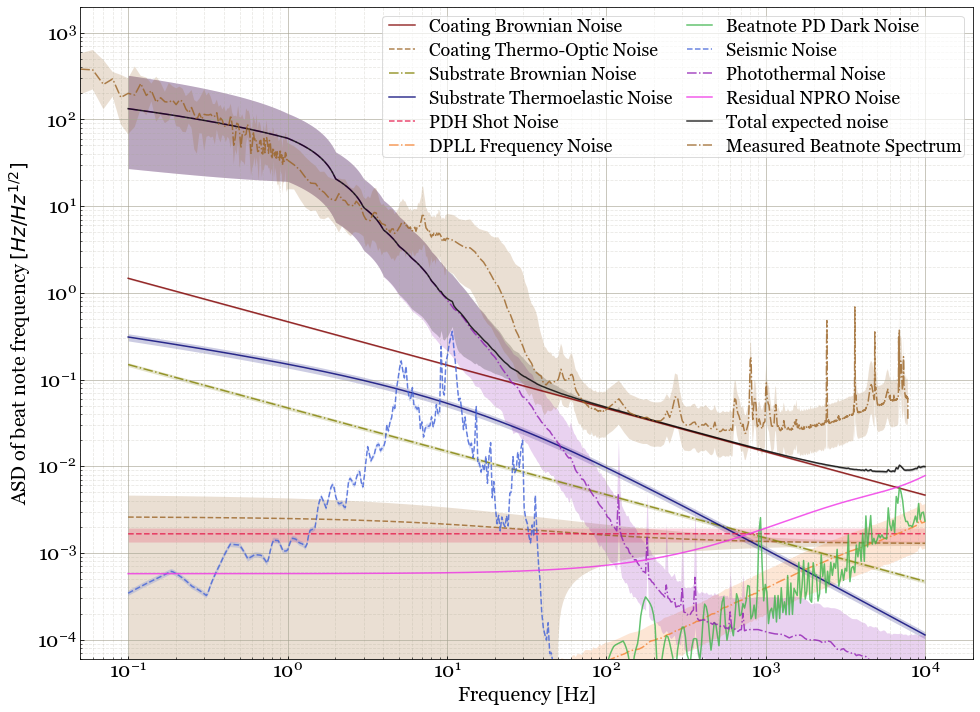

In [20]:
plotList = ['coatBr', 'coatTO', 'subBr', 'subTE',
            'pdhShot', 'pllOsc', 'pllReadout', 'seismic',
            'photoThermal', 'resNPRO', 'total', 'beat']
nosbud.PSDList['pllOsc'][2] = 'DPLL Frequency Noise'
fig = nosbud.plotPSD(plotList=plotList,
                     savePlot=False,
                     doTotal=True)
fn = BNfile.replace('.txt', '')
tstamp = fn[fn.find('Spectrum_')+9:]
tstruc = time.strptime(tstamp, '%Y%m%d_%H%M%S')
BNdate = time.strftime('%b %d, %Y', tstruc)
ax = fig.gca()
ax.set_xlim([0.05, 2e4])
ax.set_title('')

In [21]:
#fig.savefig('/Users/anchal/Git/writing-presenting/CTN_DAMOP_Poster/figures/CTN_Noise_Budget.pdf',
#            facecolor=fig.get_facecolor(),
#            bbox_inches='tight')

In [22]:
ax.set_title('CTN Noise Budget, '
             + BNdate
             + '\n'
             + r'$\Phi_{B} = 8.9^{8.9}_{5.0} \times 10^{-4}$' + ' radians; '
             + r'$\Phi_{S} = 5.2 \times 10^{-7}$' + ' radians')
figlist += [fig]

In [23]:
pp = PdfPages('CTN_Bayesian_Inference_Analysis_Of_Best_Result.pdf')
for fig in figlist:
    pp.savefig(fig, bbox_inches='tight')
pp.close()